# **GIS × Python Tutorial Session8 ~ DTMの後処理 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>



## **はじめに**
---
前回の記事では CSF による点群データ分類と DTM の作成を行いました。しかし作成した DTM は所々穴が開いていたり、その他に地表付近の地物が影響していたのか、ボコボコとした形になっていました。

この記事では、穴（欠損）を埋めしたり、データを滑らかにする為の後処理について解説します。


https://zenn.dev/daidai_daitai/articles/597bd52ed96dfd
<br><br><br>

 - RasterDataを使用する為のライブラリー
    - RasterDataの読み込み
    - Metadataの確認
    - RasterDataのPlot

 - 穴埋め（欠損値の補完）

 - 平滑化
   - データの確認
   - 



## **今回使用するデータ**
---
今回は前回の記事で作成した DTM を使用します。

<br><br><br>



## **インポート**
---

In [1]:
import json
import pprint

import geopandas as gpd
from IPython.display import Image
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pdal
import pyproj
import rasterio
import rasterio.fill
import shapely
from shapely.plotting import plot_polygon
plt.style.use('seaborn-v0_8-whitegrid')
japanize_matplotlib.japanize()


# 読み込みファイル
FILE_PATH = '../datasets/01ID7913_DTM_R05.tif'
# 静岡県のEPSGコード
IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

## **RasterDataを使用する為のライブラリー**
---
今回は RasterData を使用する為のライブラリーとして `rasterio` を使用します。

rasterio では Raster の読み書きや加工を行う事が出来ます。`GDAL` の方が有名かもしれませんが、個人的にはドキュメントも読みやすく、大体の場合は rasterio を使用しています。

https://rasterio.readthedocs.io/en/latest/index.html

### **RasterDataの読み込みとメタデータの確認**
Raster の読み込みは非常に簡単です。読み込んだデータからメタデータも確認して、前回の記事で定義した空間参照系などが記録されているか見てみましょう。

In [2]:
ds = rasterio.open(FILE_PATH)

print(f"""metadata ...
type  : {type(ds)}
epsg  : {ds.crs.to_epsg()} 
shape : {ds.shape}
height: {ds.height}
width : {ds.width}
""")

metadata ...
type  : <class 'rasterio.io.DatasetReader'>
epsg  : 6669 
shape : (1501, 2001)
height: 1501
width : 2001



**'DatasetReader.bounds'** で Raster の範囲を確認する事が出来ます。データは、**(left=x_min, bottom=y_min, right=x_max, top=y_max)** の順で格納されています。

In [3]:
bounds = ds.bounds
print(bounds)

BoundingBox(left=-4000.0, bottom=37500.0, right=-2999.5, top=38250.5)


ちなみに Raster の範囲を示す **'shapely.Polygon'** の geometry を作成したい場合は、**'shapely.box'** に渡せば作成できます。

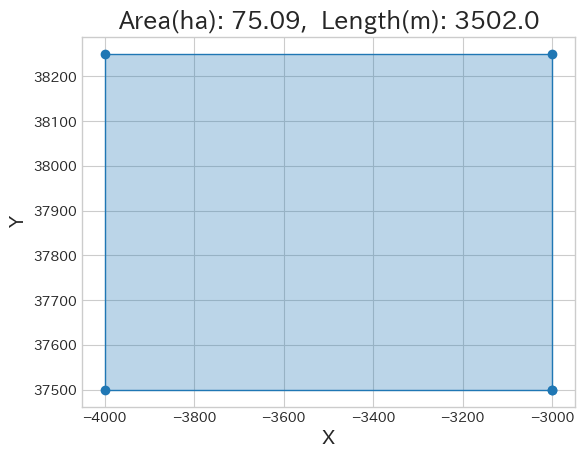

In [4]:
scope = shapely.box(*bounds)

fig, ax = plt.subplots()
plot_polygon(scope)
title = f"Area(ha): {round(scope.area / 10_000, 2)},  Length(m): {scope.length}"
ax.set_title(title, fontsize=18)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14);

地上分解能を計算してみましょう。

In [5]:
x_distance = abs(bounds.left - (bounds.right))
y_distance = bounds.top - bounds.bottom

x_resolution = x_distance / ds.width
y_resolution = y_distance / ds.height

print(f"""resolution(m): {x_resolution} × {y_resolution}""")

resolution(m): 0.5 × 0.5


### **Raster の可視化**
Raster は画像と同じく行列のデータなので、matplotlib で可視化する事が出来ます。

まずは Raster の 枚数を確認しましょう。今回はDTMなので、1枚しか存在しませんが、RGBの画像ならば3枚表示されます。0始まりではなく、1始まりなので注意しましょう。

In [6]:
# 
ds.indexes

(1,)

行列を読み込んで、可視化してみましょう。

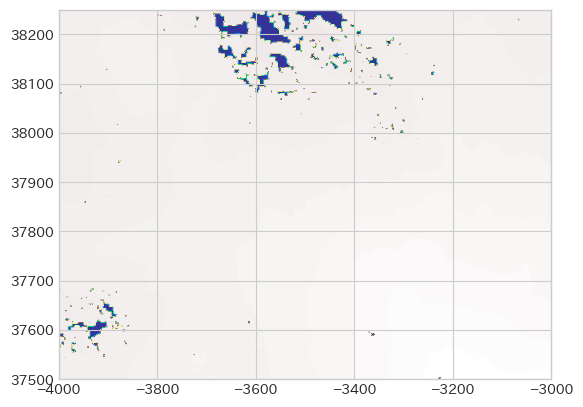

In [29]:
# 'read'では'indexes'で確認した番号を指定します。
dtm_ary = ds.read(1)
# 描画の範囲をmatplotlibのlimに適用させる
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
plt.imshow(dtm_ary, extent=extent, cmap='terrain');

欠損値が邪魔して綺麗に可視化されていません。最小値を見てみましょう。

In [30]:
np.min(dtm_ary)

-9999.0

最小値が負の値なので、可視化する値の範囲に制限を掛けます。

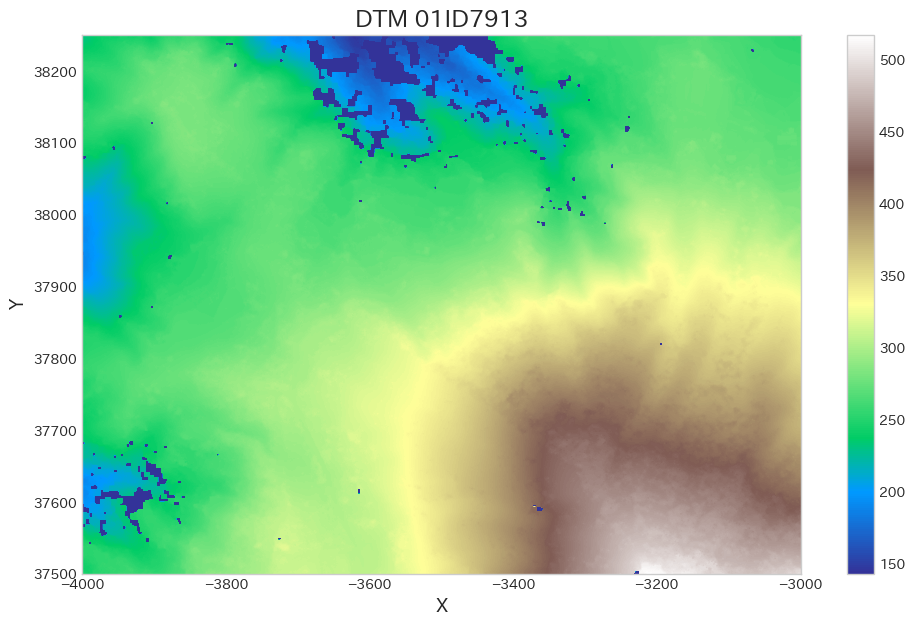

In [31]:
plt.figure(figsize=(12, 7))
plt.imshow(
    dtm_ary, 
    # 画像の範囲（座標）をlimに設定
    extent=extent, 
    # 'cmap'は好きなモノでいいが、丁度'terrain'という名前があるので...
    cmap='terrain', 
    # 0より大きな数値の中の最小値を設定
    vmin=np.min(dtm_ary[0 < dtm_ary])
)
plt.grid(False)
plt.colorbar()
plt.title('DTM 01ID7913', fontsize=17)
plt.xlabel('X', fontsize=13)
plt.ylabel('Y', fontsize=13);

## **穴埋め（欠損値補完）**
rasterio の **'rasterio.fill.fillnodata'** で、欠損値の補完を行う事が出来ます。これには 'mask'として、同じ形状の配列を渡す必要があります。mask 配列は **"欠損値がある場所を 0 それ以外には 255"** を入力したものが必要です。ただし、別に自分で作成しなくとも 'DatasetReader.read_masks' で取得する事も可能です。

単純にこれを実行すると、元の 'dtm_ary' にも穴埋めが適用されるので（参照渡し）、copy をして元データを変更しない様にします。

In [35]:
dtm_fill = rasterio.fill.fillnodata(
    # DTMの行列をCopyして渡す
    image=dtm_ary.copy(),
    mask=ds.read_masks(1),
    # 補完する場合にどこまで離れたセルまで検索するか。デフォルトが100です。
    max_search_distance=100,
    smoothing_iterations=2
)

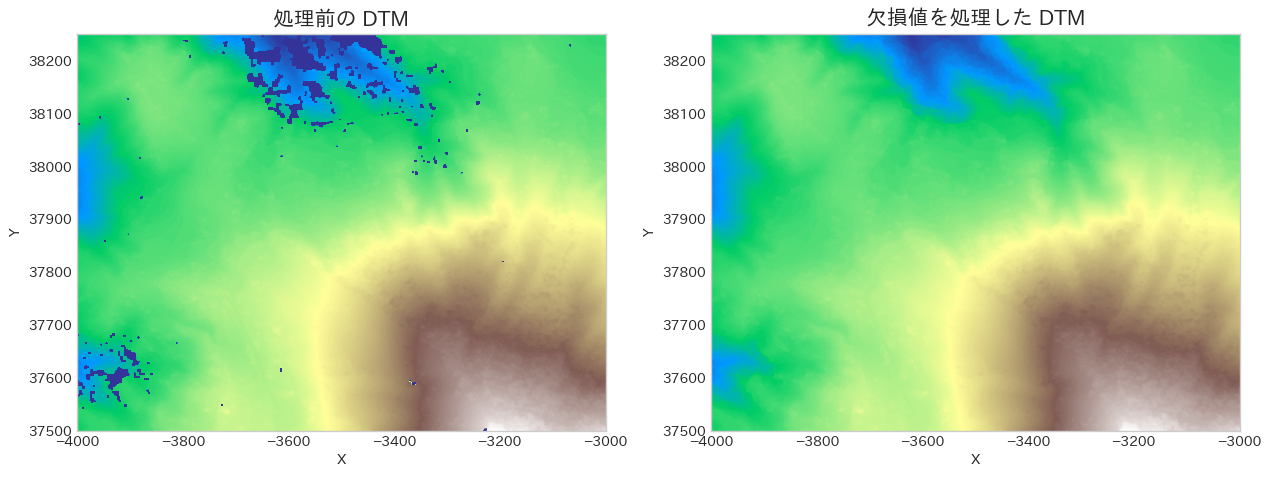

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].imshow(
    dtm_ary, extent=extent, 
    cmap='terrain', vmin=np.min(dtm_ary[0 < dtm_ary])
)
ax[1].imshow(
    dtm_fill, extent=extent, 
    cmap='terrain', vmin=np.min(dtm_ary[0 < dtm_ary])
)
for _ax, title in zip(ax, ['処理前の DTM', '欠損値を処理した DTM']):
    _ax.grid(False)
    _ax.set_title(title, fontsize=15)
    _ax.set_xlabel('X')
    _ax.set_ylabel('Y')

## **平滑化**